# querying Aris from CasJobs : Count objects in low-level HEALPix cells

Prerequisites:

* pip install healpy

In [1]:
import SciServer.CasJobs as cj
from datetime import datetime
import pandas
import matplotlib.pyplot as plt
import healpy
import numpy as np
from datetime import datetime

In [2]:
LSST="LSST_aris"
# code for perfect(unit?) sphere
SRID=104001

## count Object rows in HEALPix cells at level LEVEL
Various different version of table used

In [3]:
%%time
#
# use temptable #a iso defining it inside CTE, as otherwise it will be executed multiple times in the union
#
def queryHEALPixCounts(object_table,level):
    print("[",datetime.now(),"] table:",object_table,", level:",level)
    pow=20-level
    sql="""
select healpixid/power(4,{pow}) as healpixid_L, count(*) as num
  from {object_table}
 group by  healpixid/power(4,{pow}) 
 order by 1
    """.format(pow=20-level,object_table=object_table)
    return cj.executeQuery(sql,LSST)

CPU times: user 0 ns, sys: 21 µs, total: 21 µs
Wall time: 41.5 µs


In [4]:
ORDER=5
NSIDE=2**ORDER

In [12]:
%time healpix5_dp_test=queryHEALPixCounts('dp.Object_test',ORDER)


[ 2020-01-28 11:27:27.921407 ] table: dp.Object_test , level: 5
CPU times: user 38.5 ms, sys: 8.44 ms, total: 47 ms
Wall time: 8.84 s


In [13]:
healpix5_dp_test.sum()

healpixid_L      95028
num            2108307
dtype: int64

# Plotting

In [14]:
hpmap=np.full(healpy.nside2npix(NSIDE), healpy.UNSEEN)
hpmap[healpix5_dp_test['healpixid_L']]=healpix5_dp_test['num']

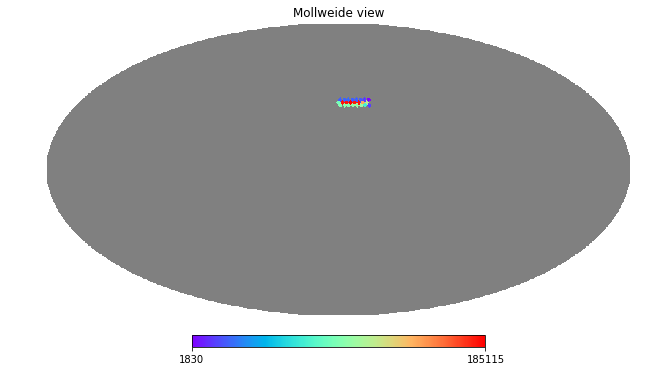

In [15]:
healpy.mollview(hpmap,cmap='rainbow',badcolor='grey',nest=True)

In [16]:
sql="""
select top 100000 ra,decl
  from dp.Object_test
  order by newid()
"""
df=cj.executeQuery(sql,LSST)

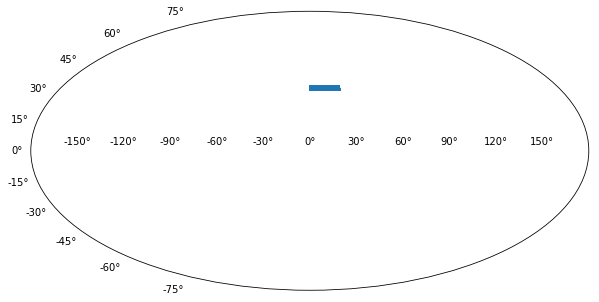

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='mollweide')
lon=-np.deg2rad(df['ra']+180)% (2 * np.pi) - np.pi
lat=np.deg2rad(df['decl'])
im = ax.scatter(lon,lat,s=1)